In [2]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Scapy Settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [3]:
# Load the pbmc3k dataset
sc.datasets.pbmc3k()
adata = sc.read_10x_mtx(
    # the directory with the `.mtx` file
    './data/filtered_gene_bc_matrices/hg19/',
    # use gene symbols for the variable names (variables-axis index)
    var_names='gene_symbols',
    # write a cache file for faster subsequent reading
    cache=True,
)

adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
adata.write('write/pbmc3k_raw.h5ad', compression='gzip')
print(adata)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


normalizing counts per cell
    finished (0:00:00)


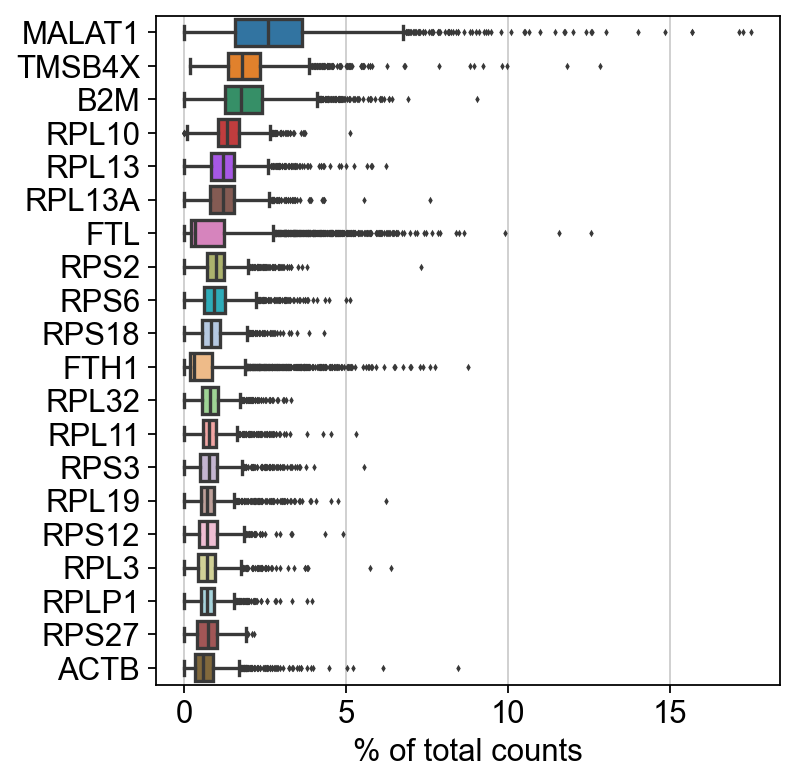

In [4]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

In [5]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


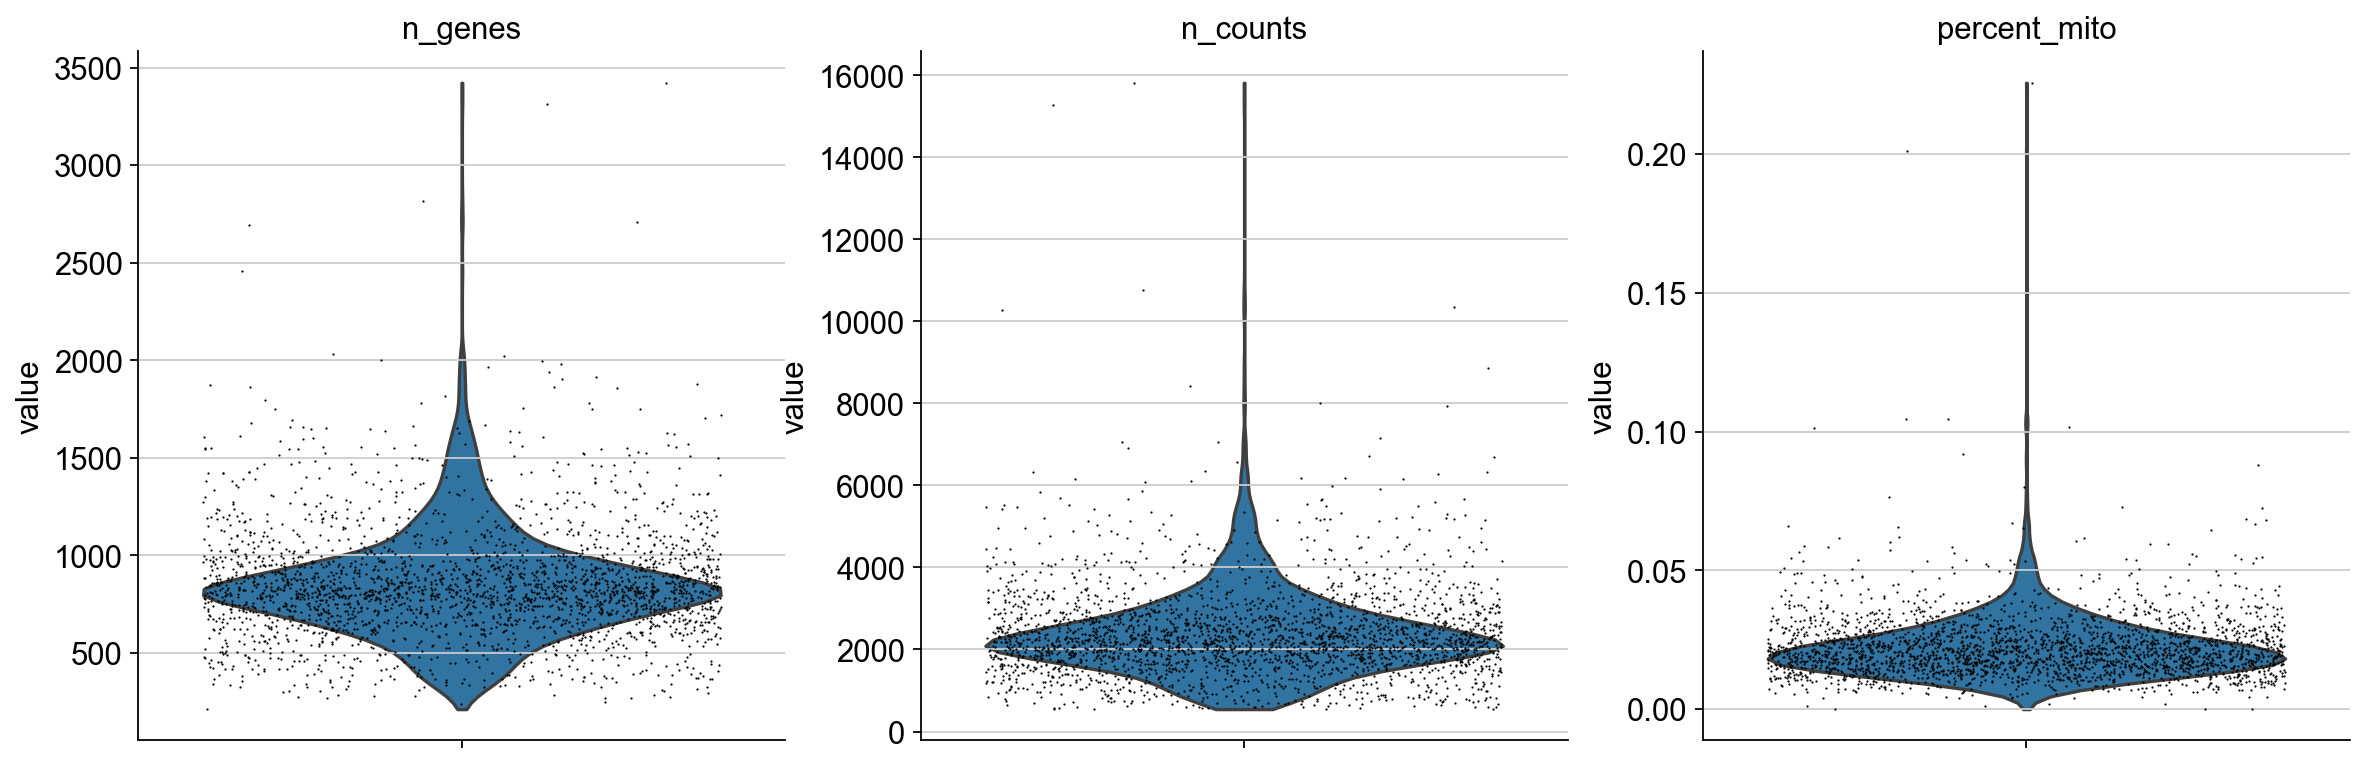

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


In [6]:
# quality control
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                jitter=0.4, multi_panel=True)

adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)


In [7]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)


normalizing counts per cell


    finished (0:00:00)


In [8]:
# Store the raw data
adata.raw = adata

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


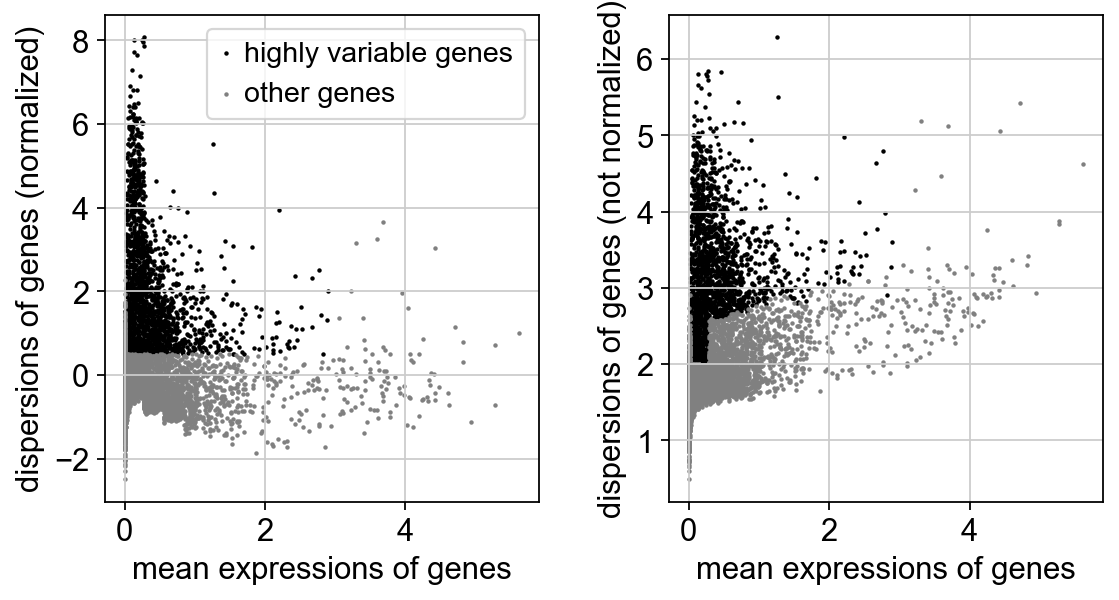

1838


In [9]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Filter the data
adata = adata[:, adata.var.highly_variable]

# Summarize the highly variable genes
print(adata.var.highly_variable.sum())


In [10]:
# # Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.
# sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

In [11]:
# # Scale each gene to unit variance. Clip values exceeding standard deviation 10 to remove extreme outliers.
# sc.pp.scale(adata, max_value=10)

In [12]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## Dimension Reduction

### GrandPrix

In [13]:
# Import Libray 
from  GrandPrix import GrandPrix

In [14]:
# convert adata to df
df = pd.DataFrame(adata.X.toarray(), index=adata.obs.index, columns=adata.var.index)

# convert df to numpy array
Y = df.values
N, D = Y.shape
print('Cells: %s, Genes: %s'%(N, D))

Cells: 2638, Genes: 1838


In [19]:
np.random.seed(10)

#### 2-D tSNE 

In [20]:
# Aplly tsne to the adata
sc.tl.tsne(adata, random_state=2, n_pcs=10, n_jobs=4)

# save the tsne coordinates in a dataframe
tsne = pd.DataFrame(adata.obsm['X_tsne'], index=adata.obs.index, columns=['X1', 'X2'])
tsne.head()


computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:06)


,X1,X2
AAACATACAACCAC-1,-11.259717,18.551939
AAACATTGAGCTAC-1,3.431066,-52.459404
AAACATTGATCAGC-1,-39.562103,26.744865
AAACCGTGCTTCCG-1,48.145332,-9.307588
AAACCGTGTATGCG-1,5.190978,61.348377


In [21]:
# Intialize the GrandPrix model
def MapTo01(y):             # convert y to [0, 1]
    return (y.copy() - y.min(0)) / (y.max(0) - y.min(0))

Q = 2 # Latent dimensions
X_mean = np.zeros((N, Q)) # initialisation of latent_mean 
X_mean[:, 0] = MapTo01(tsne['X1'].values)
X_mean[:, 1] = MapTo01(tsne['X2'].values)

In [22]:
# Setting up the model params
indPoints = pd.read_csv('data/init_inducing.csv', index_col=[0])
M = 60 # Number of inducing points
Z = np.zeros((M, Q)) # initialisation of inducing input points 
Z[:, 0] = np.random.permutation(indPoints['D1'].values)[:M]
Z[:, 1] = np.random.permutation(indPoints['D2'].values)[:M]

In [66]:
# Setting the GrandPrix model
model = GrandPrix.fit_model(data=Y, X_mean=X_mean, Z=Z, kern='RBF', Q=Q, M=M, N=N, D=D)

TypeError: Error calling wrapped function (see above error). If you believe your parameters actually are correct, the error can sometimes be fixed by setting `tf_decorator=True` on your `@check_shapes` decorator.